# Training a network against an ensemble of model simulations

This script aims to train a CNN model against an ensemble of burgers model simulations.
The data can be generated with `generate_model_1d_burgers.ipynb`. 
A more elaborate description of the training process is available in `training_model_1d_burgers_minimal.ipynb`
and a description with demo of the model in `../model_1d/model_1d_burgers.ipynb`

## Aim of this script

The aim is to set up a robust and efficient training on cpu and gpu for a reasonable dataset to make the training
more reproducable and robust.

In [1]:
# Initialize the Julia environment

# swithch to the directory where this script is located
cd(@__DIR__)
# Packages
using Pkg
Pkg.activate(".")

#Pkg.instantiate() # uncomment if you want to install the packages

# Load the required packages
using Flux
using BSON
using Plots, Measures
using JLD2
using ProgressMeter

# optional gpu usage
const use_gpu = false
if use_gpu
    using cuDNN, CUDA
    CUDA.allowscalar(false) # disable scalar operations on GPU
    if CUDA.functional() # check if CUDA is functional
        println("CUDA is functional, using GPU")
    else
        error("CUDA is not functional, using CPU")
    end
end

  Activating project at `~/dellete/src/julia_ml_tests.jl.git/training_1d_flux`


In [12]:
# Settings

# training
n_epochs = 256
batch_size = 64
learning_rate = 0.005

# data
input_file = joinpath(".", "burgers1d_periodic_ensemble.jld2")
train_fraction = 0.7 # fraction of training samples
val_fraction = 0.15 # fraction of validation samples

# model
n_in = 1 # number of input channels (X)
n_out = 1 # number of output channels (Y)
n_hidden = 8 # number of hidden features in the model
n_filter= 3 # width of the convolutional filter

nothing

In [34]:
# Load the data and convert it to input and output arrays

# check if the input file exists
if !isfile(input_file)
    println("Data file not found: $input_file")
end
println("Loading data from $input_file")
data=load(input_file)
solution=data["solution"] # nexted array of size (n_ens, n_times, nx)

# sizes
n_ens=length(data["solution"]) # number of ensemble members
n_times=length(solution[1]) # number of time points
nx=length(solution[1][1]) # number of grid points
n_steps=n_times-1 # number of time steps in the data
println("Data size: nx=$nx, n_times=$n_times, n_ens=$n_ens, n_steps=$n_steps")

# Create inputs X and outputs Y
# Tensor shape: grid-points x channels x time-steps
n_samples=n_steps*n_ens
X = zeros(Float32,nx,1,n_samples) # Float32 for GPU compatibility, 1 channel since only one variable u
Y = zeros(Float32,nx,1,n_samples) 
for i in 1:n_ens #loop over ensemble members
    # println("Ensemble member $i of $n_ens")
    for t in 1:n_steps #copy data to the tensors
        X[:,1,t + (i-1)*n_steps] .= solution[i][t]
        Y[:,:,t + (i-1)*n_steps] .= solution[i][t+1]
    end
end
@show size(X)
@show size(Y)

# some metadata for plotting
output_times = data["times"][:]
output_x = data["grid"]
x0= data["solution"][end][1] # initial condition for rollout
x0_rollout=data["solution"][end][:] # reshape to tensor
nothing

Loading data from ./burgers1d_periodic_ensemble.jld2
Data size: nx=100, n_times=51, n_ens=100, n_steps=50
size(X) = (100, 1, 5000)
size(Y) = (100, 1, 5000)


In [7]:
# Split the data into training and validation sets

# Calculate split sizes
n_train = Int(floor(train_fraction * n_samples))
n_val = Int(floor(val_fraction * n_samples))
# Split the data into training and validation sets
X_train_cpu = X[:,:,1:n_train]
Y_train_cpu = Y[:,:,1:n_train]
X_val_cpu = X[:,:,n_train+1:n_train+n_val]
Y_val_cpu = Y[:,:,n_train+1:n_train+n_val]

@show size(X_train_cpu), size(Y_train_cpu)
@show size(X_val_cpu), size(Y_val_cpu)

(size(X_train_cpu), size(Y_train_cpu)) = ((100, 1, 3500), (100, 1, 3500))
(size(X_val_cpu), size(Y_val_cpu)) = ((100, 1, 750), (100, 1, 750))


((100, 1, 750), (100, 1, 750))

In [8]:
# move data to gpu or keep on cpu
if use_gpu
    X_train = gpu(X_train_cpu)
    Y_train = gpu(Y_train_cpu)
    X_val = gpu(X_val_cpu)
    Y_val = gpu(Y_val_cpu)
else
    X_train = X_train_cpu
    Y_train = Y_train_cpu
    X_val = X_val_cpu
    Y_val = Y_val_cpu
end

# create the data loaders
train_loader = Flux.DataLoader((X_train, Y_train), batchsize=min(batch_size,n_train), shuffle=true)

val_loader = Flux.DataLoader((X_val, Y_val), batchsize=min(batch_size,n_val), shuffle=false)

@show train_loader
@show val_loader
nothing

train_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, shuffle=true, batchsize=40)
val_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, batchsize=40)


In [13]:
# Create the model
n_pad=n_filter ÷ 2 # padding for the convolutional layer
PadCircular(x) = pad_circular(x, (n_pad,n_pad,0,0,0,0))

model_residual = Chain(
    PadCircular,
    Conv((n_filter,), n_in=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_out)
)

# Define the model with residual block
struct ResidualBlock
    f::Chain
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# create the model with residual blocks
model_cpu = ResidualBlock(model_residual)

# Show the model strucure and number of parameters
@show model_cpu

# Move model to gpu or keep on cpu
if use_gpu
    model = gpu(model_cpu)
else
    model = model_cpu
end

model_cpu = ResidualBlock(Chain(PadCircular, Conv((3,), 1 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 1)))


ResidualBlock(
  Chain(
    Main.PadCircular,
    Conv((3,), 1 => 8, swish),          # 32 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 1),                 # 25 parameters
  ),
)                   # Total: 8 arrays, 457 parameters, 2.387 KiB.

In [14]:
# Train the model

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(learning_rate),model)

# train loop
train_loss = Float32[]
val_loss = Float32[]
@showprogress for epoch in 1:n_epochs
    # Train the model on the training data
    # Loop over minibathches in the training data
    for (x_batch, y_batch) in train_loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x_batch) # apply the model to the input batch
            Flux.mse(y_hat, y_batch) # compute the loss
        end
        Flux.update!(optimizer, model, grads[1])
    end
    # evaluate over all training data and validation data
    # NOTE: we careless with compute, rerunning model each time below
    Y_train_hat = model(X_train)
    train_loss_epoch = Flux.mse(Y_train_hat, Y_train)
    push!(train_loss, train_loss_epoch)
    Y_val_hat = model(X_val)
    val_loss_epoch = Flux.mse(Y_val_hat, Y_val)
    push!(val_loss, val_loss_epoch)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:02:23


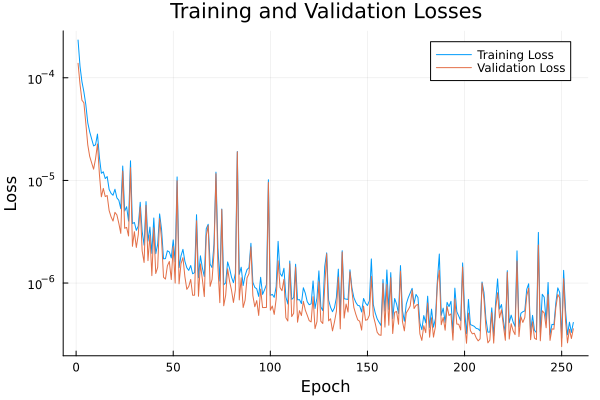

In [15]:
# Plot losses for training and validation
plot(train_loss, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training and Validation Losses",yscale=:log10)
plot!(val_loss, label="Validation Loss", xlabel="Epoch",yscale=:log10)

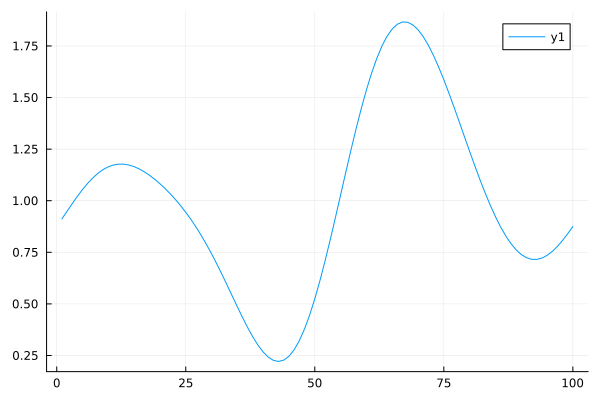

In [16]:
plot(X_train_cpu[:,1,151])

In [35]:
# unroll the model to get the output for the initial condition
function unroll(model, x0, n_steps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float32, size(x0, 1), size(x0, 2), n_steps+1)
    outputs[:,:,1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:n_steps
        x = model(x)
        outputs[:,:,t+1] .= x
    end
    return outputs
end

# unroll the model to get the output for the initial condition
model_cpu = model |> cpu # move model to cpu for unrolling
Y_unroll = unroll(model_cpu, f32(x0), n_steps)

nothing

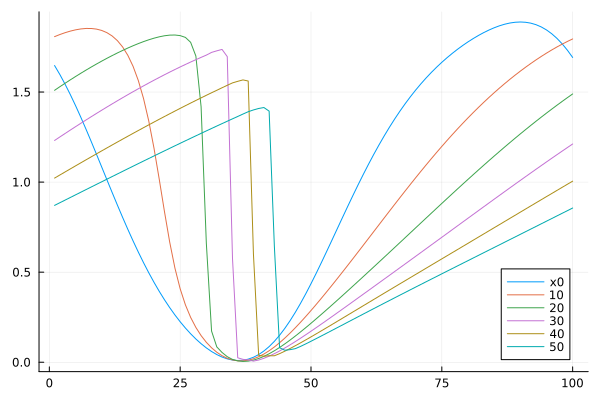

In [21]:
# plot some snapshots of the unrolled model output
plot(Y_unroll[:, 1, 1], label="x0")
plot!(Y_unroll[:,1,11], label="10")
plot!(Y_unroll[:,1,21], label="20")
plot!(Y_unroll[:,1,31], label="30")
plot!(Y_unroll[:,1,41], label="40")
plot!(Y_unroll[:,1,51], label="50")

┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/burgers1d_periodic_ml_unroll.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/gYkEG/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/training_1d_flux/burgers1d_periodic_ml_unroll.gif")
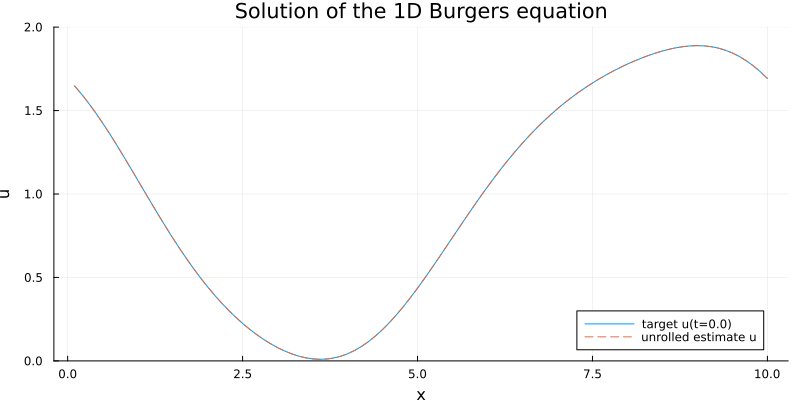

In [36]:
# Make movie of the unrolled output
function make_movie(Y, Y_target)
    nx,n_channels,n_times=size(Y)
    # create a movie of the solution
    anim = @animate for i in 1:n_times
        p1 = plot(output_x, Y_target[i], label="target u(t=$(round(output_times[i],digits=2)))", xlabel="x", ylabel="u", ylim=(0, 2))
        plot!(output_x, Y[:,1,i], label="unrolled estimate u", linestyle=:dash)
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic_ml_unroll.gif", fps=15)
end
make_movie(Y_unroll, x0_rollout)